This notebook explores the duplicate and non-duplicate set of samples in the training set by using similarity scores of their sentence embeddings and also highlights incorrectly labelled cases.

In [ ]:
! pip install bert-for-tf2

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


In [13]:
! unzip sample_data/train.csv.zip

Archive:  sample_data/train.csv.zip
  inflating: train.csv               


In [ ]:
# Size of train.csv

! du -sh ./*

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import bert

In [16]:
train_df = pd.read_csv("./train.csv")

In [17]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### Distribution of classes - is duplicate / not-duplicate

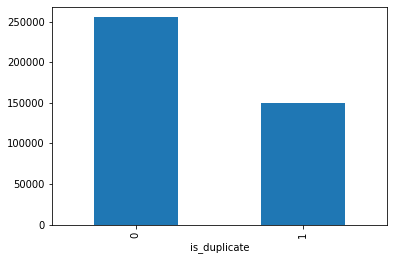

In [19]:
train_df.groupby("is_duplicate").count()['id'].plot.bar()
plt.show()

### Null values

In [20]:
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [21]:
train_df[train_df['question1'].isnull()].head()

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English name is most suitable for me considering the pronounciation of my Chinese name?,0


In [22]:
train_df[train_df['question2'].isnull()].head()

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [23]:
# Removing rows with Null questions

train_df = train_df[~train_df['question1'].isnull()]
train_df = train_df[~train_df['question2'].isnull()]

In [24]:
train_df.count()

id              404287
qid1            404287
qid2            404287
question1       404287
question2       404287
is_duplicate    404287
dtype: int64

### Exploring similarity scores between question pairs using Language-Agnostic-Bert-Sentence embedding model

[LABSE](https://ai.googleblog.com/2020/08/language-agnostic-bert-sentence.html) - is a multilingual model to preduce sentence embeddings based on Bert and combines methods for obtaining sentence embeddings with MLM and Translation Language Model pretrained encoders. 

It is trained on Monolingual data and bilingual translation pairs.

In [25]:
LABSE_model_URL = "https://tfhub.dev/google/LaBSE/1"
MAX_SEQ_LENGTH = 64

LABSE model is available from TFhub and is loaded from there to wrap it as a callable object and to be used as a Keras Layer. Its vocab_file is stored as atf.saved_model.Asset and the do_lower_case flag is stored as a tf.Variable object on the SavedModel.

In [26]:
## Define Model containing LABSE as Keras layers

def getModel(model_url, max_seq_length):
    # Load the saved LaBSE model as Keras layer. 
    # Set trainable to True to enable weight update for fine-tuning the model for down stream task
    labse_layer = hub.KerasLayer(handle=model_url, trainable=True, name='labse')

    # Define Inputs
    input_word_ids = tf.keras.Input(shape=(max_seq_length, ), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(max_seq_length, ), dtype=tf.int32, name='input_mask')
    input_segment_ids = tf.keras.Input(shape=(max_seq_length, ), dtype=tf.int32, name='input_segment_ids')

    # LABSE layer 
    pooled_output, _ = labse_layer([input_word_ids, input_mask ,input_segment_ids])

    # The output is L2 normalized shape [batch_size, 768] representing a complete sentence embedding
    pooled_output = tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), name='l2_normalized_pooling')(pooled_output)

    # Define Model
    return tf.keras.Model(inputs=[input_word_ids, input_mask ,input_segment_ids], outputs=pooled_output), labse_layer

In [27]:
## Input preparation
labse_model, labse_layer = getModel(LABSE_model_URL, MAX_SEQ_LENGTH)

# labse_layer = hub.KerasLayer(handle=LABSE_model_URL, trainable=True, name='labse')

vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()  # Get vocab file path as numpy array 
do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()   # Get Boolean Variable as numpy array
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

print(vocab_file, do_lower_case)

b'/tmp/tfhub_modules/0bc004950cec35a1a895621e888926cac85cbeba/assets/cased_vocab.txt' False


In [28]:
labse_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_segment_ids (InputLayer)  [(None, 64)]         0                                            
__________________________________________________________________________________________________
labse (KerasLayer)              [(None, 768), (None, 470926849   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [29]:
def create_input(input_strings, tokenizer, max_seq_length):
    input_ids_all, input_mask_all, segment_ids_all = [], [], []
    
    for input_string in tqdm(input_strings):
        # Tokenize input
        # print("{}".format(i))
        input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
        sequence_length = min(len(input_ids), max_seq_length)

        # Padding or truncation.
        if len(input_ids) >= max_seq_length:
          input_ids = input_ids[:max_seq_length]
        else:
          input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

        input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

        input_ids_all.append(input_ids)
        input_mask_all.append(input_mask)
        segment_ids_all.append([0] * max_seq_length)

    return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)

In [30]:
def encode(input_text):
    input_ids, input_mask, segment_ids = create_input(input_text, tokenizer, MAX_SEQ_LENGTH)
    return labse_model.predict([input_ids, input_mask, segment_ids])

Taking a sample of 100k Question pairs from the dataset

In [31]:
sample_df = train_df
question1_array = sample_df['question1'].values
question2_array = sample_df['question2'].values

%time question1_embeddings = encode(question1_array)

100%|██████████| 404287/404287 [00:59<00:00, 6815.71it/s]


CPU times: user 4min 28s, sys: 1min 7s, total: 5min 35s
Wall time: 32min 1s


In [32]:
%time question2_embeddings = encode(question2_array)

100%|██████████| 404287/404287 [01:00<00:00, 6643.91it/s]


CPU times: user 4min 35s, sys: 1min 8s, total: 5min 44s
Wall time: 32min 18s


In [33]:
question1_embeddings.shape, question2_embeddings.shape

((404287, 768), (404287, 768))

In [35]:
product = question1_embeddings * question2_embeddings
print(product.shape)

cosine_similarity = product.sum(axis=1)
cosine_similarity.shape

(404287, 768)


(404287,)

In [36]:
sample_df['similarity'] = cosine_similarity

Plotting the distribution of similarity score for  duplicate and non-duplicate question pairs

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


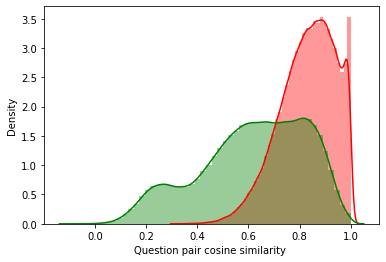

In [39]:
sns.distplot(sample_df[sample_df['is_duplicate'] == 1.0]['similarity'][0:] , label = "1", color = 'red')
sns.distplot(sample_df[sample_df['is_duplicate'] == 0.0]['similarity'][0:] , label = "0", color = 'green')
plt.xlabel("Question pair cosine similarity ")
plt.show()

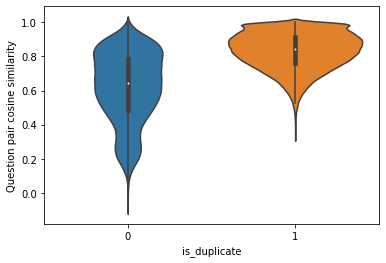

In [40]:
sns.violinplot(x = 'is_duplicate', y = 'similarity', data = sample_df[0:])
plt.ylabel("Question pair cosine similarity")
plt.show()

From the similarity score obtained using sentence embeddings of pretrained LABSE model, the median of distribution of similarity score for both duplicate and non-duplicate questions is higher than 0.5. 

Let's look into more detail for each case next.

### Duplicate question pairs

In [42]:
sample_df[sample_df['is_duplicate'] == 1].describe()['similarity']

count    149263.000000
mean     0.831287     
std      0.107942     
min      0.325554     
25%      0.760908     
50%      0.842984     
75%      0.915677     
max      1.000000     
Name: similarity, dtype: float64

##### Duplicate Question pairs with similarity score < 0.5

In [63]:
duplicate_low_simlarity_prop = sample_df[(sample_df['is_duplicate'] == 1) & (sample_df['similarity'] < 0.5)]['similarity'].count() / sample_df[sample_df['is_duplicate'] == 1]['similarity'].count()

print(" {} percent of duplicate question pairs have similarity score less than 0.5 ".format(duplicate_low_simlarity_prop * 100))

 0.36244749201074616 percent of duplicate question pairs have similarity score less than 0.5 


In [44]:
sample_df[(sample_df['is_duplicate'] == 1) & (sample_df['similarity'] < 0.5)].describe()['similarity']

count    541.000000
mean     0.461011  
std      0.034763  
min      0.325554  
25%      0.443392  
50%      0.470374  
75%      0.489232  
max      0.499840  
Name: similarity, dtype: float64

In [52]:
# Going through top question pairs with lowest similarity scores

sample_df[(sample_df['is_duplicate'] == 1)][['question1', 'question2','similarity']].sort_values(by='similarity').head(10)

,question1,question2,similarity
329901,Who won the 09/26/16 debate? Does it matter?,According to polls who won the first Clinton-Trump presidential debate?,0.325554
354027,Robert Frost: Was the moon landing a hoax?,Prouve me the moon landing is true..,0.329183
376277,Will India ever get rid of the reservation system from all the sectors be it education or jobs?,"Will we ever get ""Azaadi"" from cast based Reservation?",0.333737
345136,"In your opinion, who won the first Trump–Clinton U.S. Presidential debate?",Who won the 09/26/16 debate? Does it matter?,0.337556
366855,What is the evidence that India carried out surgical strikes in PoK? What made the world deny India's claim?,Were the surgical strikes carried out or not?,0.338138
210780,Does skipping increase height?,I am 19 years old girl and my height is 5'3. How can I increase my height?,0.356923
343355,I am 19 years old girl and my height is 5'3. How can I increase my height?,Do running increase your height?,0.364564
13587,Why did you cry?,"In ten words or less, what makes you cry?",0.365241
390426,Today pm speech is effective or not?,What could we conclude from PM Modi's Speech on 13th November?,0.365805
111953,How long does it take for an avid weed smoker to pass a urine drug test?,I smoked weed for 3 days. I was clean before that. I had to take a drug test 2 weeks after. I took a home test and barely passed. Will I pass the lab test?,0.366012


In [65]:
# Going through top question pairs with highest similarity scores.

sample_df[(sample_df['is_duplicate'] == 1)][['question1', 'question2','similarity']].sort_values(by='similarity', ascending=False).head(10)

,question1,question2,similarity
113842,What are some of the Great facts about Maharana Pratap?,What are some of the Great facts about Maharana Pratap?,1.0
271466,I earn INR 30k/month. After paying rent I save around 10k. How can I save and invest so that after 10years I get a monthly interest of around 6k?,I earn INR 30k/month.After paying rent I save around 10k. How can I save and invest so that after 10years I get a monthly interest of around 6k?,1.0
165946,Where and how can I learn terminal or cmd ?,Where and how can I learn terminal or cmd?,1.0
88243,How is 0! = 1?,How is 0! =1?,1.0
237094,How do I get internship at Google?,How do I get internship at Google ?,1.0
88180,What is x- ray astronomy?,What is x-ray astronomy?,1.0
1209,What are the minimum GPA and GRE requirements of Florida State University?,What are the minimum GPA and GRE requirements of Florida State University?,1.0
211037,How can one differentiate between 'being beautiful' and 'being good-looking'?,How can one differentiate between' being beautiful' and 'being good-looking'?,1.0
385240,Is there an air cooler with humidity control available in India?,Is there an air cooler with humidity control available in India ?,1.0
38073,Who can prove 1 = -1?,Who can prove 1= -1?,1.0


Question pairs with similarrity scores are identical in the training dataset. We'll explore non-identical.

In [71]:
# Going through top question pairs with highest similarity scores.

sample_df[(sample_df['is_duplicate'] == 1) & (sample_df['similarity'] < 0.8)][['question1', 'question2','similarity']].sort_values(by='similarity', ascending=False).head(10)

,question1,question2,similarity
341880,"If my life had absolutely no limits and I could have it all and do whatever I wanted, what would I choose to have and what would I choose to do?","Deep Thoughts: If your life had absolutely no limits and you could have it all and do whatever you wanted, what would you choose to have and what would you choose to do?",0.799999
23061,How do I make myself more productive/?,How do I make myself more productive and happy?,0.799998
355444,Who is the most popular writer at Quora?,Who has the most followers on Quora?,0.799998
403474,Why do I laugh when people get hurt?,Why do people laugh at other people when they hurt themselves?,0.799996
142488,What are the best strategies for preparing for the LSAT?,How do I prepare for LSAT?,0.799994
8034,"What is the most expensive wine, and why?",What is the most expensive wine in the world?,0.799993
256242,What is the best way to improve self-confidence?,How can I improve my confidence?,0.799991
270477,Will Hillary Clinton cause WWIII by going to war with Syria?,Would Hillary Clinton start World War III / War with Russia?,0.799991
152132,I have scored 107 in SSC CGL 2016 tier 1gen category what r my chances of selection to tier 2?,I scored 104 in SSC CGL 2016 Tier-1. Is it good enough to clear the exam given that I belong to General category ?,0.799990
285764,How can we score excellent marks in class 12th board exams?,How can I score well in the 12th class CBSE boards?,0.799989


### Non-duplicate question pairs

In [60]:
sample_df[sample_df['is_duplicate'] == 0].describe()['similarity']

count    255024.000000
mean     0.619081     
std      0.206852     
min     -0.087937     
25%      0.485433     
50%      0.642411     
75%      0.786584     
max      1.000000     
Name: similarity, dtype: float64

In [64]:
non_duplicate_high_simlarity_prop = sample_df[(sample_df['is_duplicate'] == 0) & (sample_df['similarity'] > 0.5)]['similarity'].count() / sample_df[sample_df['is_duplicate'] == 0]['similarity'].count()

print(" {} percent of Non-duplicate question pairs have similarity score more than 0.5 ".format(non_duplicate_high_simlarity_prop * 100))

 73.08018068887634 percent of Non-duplicate question pairs have similarity score more than 0.5 


In [54]:
sample_df[(sample_df['is_duplicate'] == 0) & (sample_df['similarity'] < 0.5)].describe()['similarity']

count    68652.000000
mean     0.343118    
std      0.110995    
min     -0.087937    
25%      0.254081    
50%      0.357393    
75%      0.443219    
max      0.500000    
Name: similarity, dtype: float64

Non-duplicate question pairs with similarity score > 0.5

In [53]:
sample_df[(sample_df['is_duplicate'] == 0) & (sample_df['similarity'] > 0.5)].describe()['similarity']

count    186372.000000
mean     0.720734     
std      0.125008     
min      0.500001     
25%      0.614629     
50%      0.720258     
75%      0.824017     
max      1.000000     
Name: similarity, dtype: float64

While exploring, I came across the following top instances where the question pairs are duplicate but are labelled as otherwise.

In [97]:
sample_df[(sample_df['is_duplicate'] == 0) & (sample_df['similarity'] > 0.5)].sort_values(by='similarity', ascending=False).head(23)

,id,qid1,qid2,question1,question2,is_duplicate,similarity
66762,66762,115661,115662,What should I do after completing BCA ?,What should I do after completing BCA?,0,1.000000
138069,138069,219934,219935,Why do people say philosophy is useless and/or not practical? (My view in the description),Why do people say philosophy is useless and/or not practical?(My view in the description),0,1.000000
200884,200884,302768,302769,What will be the output of the following program ?,What will be the output of the following program?,0,1.000000
194310,194310,294484,294485,How would you rephrase this sentence?,How would you rephrase this sentence?,0,1.000000
359339,359339,488974,480151,What is the meaning of this sentence below?,What is the meaning of this sentence below?,0,1.000000
35641,35641,65095,65096,What to do ?,What to do?,0,1.000000
244197,244197,356791,240063,I have read lots of books but forgotten most of them.What's the purpose of reading?,I have read lots of books but forgotten most of them. What's the purpose of reading?,0,1.000000
156320,156320,244675,66001,"When should I use ""has been"",""have been"" and ""had been""?","When should I use ""has been"", ""have been"" and ""had been""?",0,1.000000
27083,27083,50335,50336,What does the Arabic text mean ?,What does the Arabic text mean?,0,1.000000
164973,164973,256258,256259,How should I prepare ?,How should I prepare?,0,1.000000


True non-duplicate cases

In [91]:
sample_df_v2 = sample_df[(sample_df['is_duplicate'] == 0) & (sample_df['similarity'] > 0.5)]
sample_df_v2[(sample_df_v2['similarity'] <= 0.9 )].sort_values(by='similarity', ascending=False).head(10)

,id,qid1,qid2,question1,question2,is_duplicate,similarity
302662,302662,425673,313799,Why should I prepare for a medical entrance exam?,How should I prepare for my medical entrance examination?,0,0.899996
326299,326299,452595,394332,What are some things new employees should know going into their first day at US Bank?,What are some things new employees should know going into their first day at US Concrete?,0,0.899991
318728,318728,227492,36011,"What is a suitable solar panel installation provider near Oceanside, California CA?","What is a suitable solar panel installation provider near Aptos, California CA?",0,0.899987
63252,63252,110107,110108,How do I read data from excel sheet and put it into jQuery?,How do I read data from excel sheet and put it into js file?,0,0.899986
250135,250135,363927,363928,Is Canada's healthcare system a national program run by the government?,Is the U.K. healthcare system a national program run by the government?,0,0.899982
290843,290843,412205,412206,How do you change the desktop icon size in Windows 7?,How do you change the desktop icon size in Windows 10?,0,0.899980
297605,297605,419991,419992,Where is the best place to buy the iPhone 6 Plus?,Where is the best place to buy an Iphone 7 plus?,0,0.899979
149761,149761,235830,91584,What is the typical career path for someone who becomes a professor in ministry?,What is the typical career path for someone who becomes a professor in music?,0,0.899979
60534,60534,105848,105849,Why can't I connect games for Windows Live?,What can I do if I can't connect games in Windows Live?,0,0.899978
401369,401369,159134,59736,What are the best weights for weight loss?,What are the best weight loss foods?,0,0.899974


#### References
* https://github.com/Taaniya/natural-language-understanding/blob/master/Explore_Language_Agnostic_BERT_Sentence_Embedding.ipynb
* https://tfhub.dev/google/LaBSE/1